<h1 align=center><font size = 6>Finding the Best Location for New Phở Restaurant in Manhattan</font></h1>

## Introduction

In this project, I will find the top 5 neighborhoods in Manhattan for a new pho restaurant so I can deliver this report to a real estate agent who will help me find the best available location in the neighborhoods I will identify through this analysis based on real estate cost and other factors. 

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, I must download all the dependencies that we will need.

In [52]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

New York has a total of 5 boroughs and 306 neighborhoods. In order to segment the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and longitude coordinates of each neighborhood. 

Here is the link to the dataset I used as the basis for my analysis: https://geo.nyu.edu/catalog/nyu_2451_34572

Next I run a `wget` command and access the data.

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [4]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns were created as intended.

In [7]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [9]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [11]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [12]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [13]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [14]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


As we did with all of New York City, let's visualize Manhattan and the neighborhoods in it.

In [15]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'R2GV5DLRG3UMJC3C2OXZAORWIBP3WIU35NEUS3I4U3R3HKG3' # your Foursquare ID
CLIENT_SECRET = 'OGF4P1A01F1Q0R2ARWKEVKUA5AH40AF3IC1S2BZ0B2AT2LIA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R2GV5DLRG3UMJC3C2OXZAORWIBP3WIU35NEUS3I4U3R3HKG3
CLIENT_SECRET:OGF4P1A01F1Q0R2ARWKEVKUA5AH40AF3IC1S2BZ0B2AT2LIA


## 2. Retrieve Vietnamese Restaurant Venue Data From Foursquare

Now let's specify the Foursquare Vietnamese Restaurant CategoryID

Here's where things get tricky. I'll now have to create a function to create the API URL.

In [17]:
def createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit):
    url = '{}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            endpoint,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            categoryId,
            limit
        )
    return url

endpoint = 'https://api.foursquare.com/v2/venues/search?'
categoryId ='4bf58dd8d48988d14a941735'
limit = 500
radius = 500

The function below will retrieve all Vietnamese restaurants in each neighborhood

In [18]:
def getNearbyMusicVenues(neighborhoods, latitudes, longitudes, radius=1000):
    endpoint = 'https://api.foursquare.com/v2/venues/search?'
    venues_list = []   
    
    for hood_name, lat, lng in zip(neighborhoods, latitudes, longitudes):
    
        url = createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit)
        
        results = requests.get(url).json()['response']['venues']

        for item in results:
            venue_name = item['name']
            venue_category = item['categories'][0]['name']
            venue_lat = item['location']['lat']
            venue_lng = item['location']['lng']
            try:
                venue_city = item['location']['city']
            except:
                venue_city = 'N/A'
            venue_state = item['location']['state']
            
            venues_list.append([(hood_name,
                                lat,
                                lng,
                                venue_name,
                                venue_category,
                                venue_lat,
                                venue_lng,
                                venue_city,
                                venue_state
                               )])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue Name',
                             'Venue Category',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue City',
                             'Venue State'
                            ]
    return nearby_venues

manhattan_venues = getNearbyMusicVenues(manhattan_data['Neighborhood'],
                                         manhattan_data['Latitude'],
                                         manhattan_data['Longitude'],
                                         radius
                                        )


The next section will tell us how many rows and columns are in the dataframe and display the whole dataframe.

In [19]:
print(manhattan_venues.shape)
#prelim_venue_data.head(5)
manhattan_venues

(192, 9)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue City,Venue State
0,Chinatown,40.715618,-73.994279,Bêp Gà,Vietnamese Restaurant,40.717226,-73.993826,New York,NY
1,Chinatown,40.715618,-73.994279,Pho Vietnam,Vietnamese Restaurant,40.717530,-73.994128,New York,NY
2,Chinatown,40.715618,-73.994279,Saigon V-Bread Cafe LLC,Vietnamese Restaurant,40.714635,-73.993090,New York,NY
3,Chinatown,40.715618,-73.994279,Phobar,Vietnamese Restaurant,40.715215,-73.998826,New York,NY
4,Chinatown,40.715618,-73.994279,New Tu Do,Vietnamese Restaurant,40.717797,-73.995170,New York,NY
5,Chinatown,40.715618,-73.994279,Nam Son Vietnamese Restaurant,Vietnamese Restaurant,40.718215,-73.994345,New York,NY
6,Chinatown,40.715618,-73.994279,Banh Mi Saigon Bakery,Sandwich Place,40.719224,-73.996726,New York,NY
7,Chinatown,40.715618,-73.994279,Phở Grand,Vietnamese Restaurant,40.717824,-73.992801,New York,NY
8,Chinatown,40.715618,-73.994279,Vietnamese Sandwiches & Bubble Tea,Vietnamese Restaurant,40.714222,-73.997307,New York,NY
9,Chinatown,40.715618,-73.994279,Tofu Guy,Vietnamese Restaurant,40.718472,-73.995178,Manhattan,NY


Now let's create a map showing each Vietnamese restaurant in Manhattan:

In [24]:
# create map of Manhattan using latitude and longitude values
map_manhattan_vietnamese = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(manhattan_venues['Venue Latitude'], manhattan_venues['Venue Longitude'], manhattan_venues['Venue Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_vietnamese)  
    
map_manhattan_vietnamese

## 3. Analyze Each Neighborhood

# PICK BACK UP HERE

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [30]:
manhattan_viet_venue_names = manhattan_venues[['Venue Name','Neighborhood']]


In [32]:
manhattan_grouped = manhattan_viet_venue_names.groupby('Neighborhood').count()
# manhattan_grouped = manhattan_venues.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Venue Name
Neighborhood,
Carnegie Hill,3
Chelsea,4
Chinatown,31
Civic Center,16
East Village,19
Financial District,5
Flatiron,3
Gramercy,7
Greenwich Village,3


#### Let's confirm the new size

In [55]:
manhattan_grouped.shape
manhattan_grouped.sort_values('Venue Name',inplace=True)

#### Let's print each neighborhood along with the top 5 most common venues

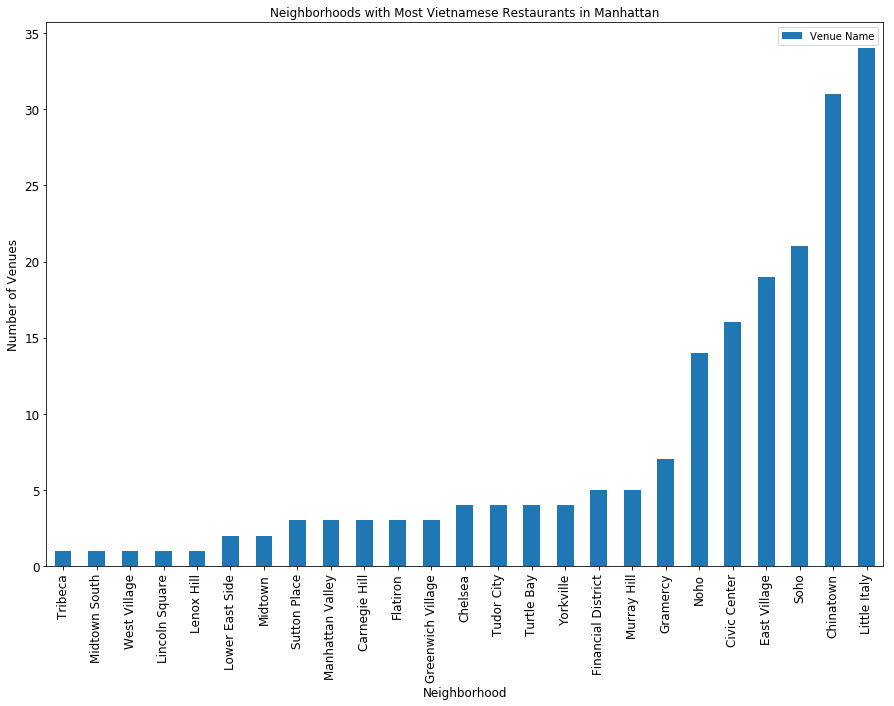

In [56]:
ax = manhattan_grouped.plot(kind='bar', title ="Neighborhoods with Most Vietnamese Restaurants in Manhattan", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Neighborhood", fontsize=12)
ax.set_ylabel("Number of Venues", fontsize=12)
plt.show()

### Based on the analysis above, the following neighborhoods have the greatest scarcity of Vietnamese restaurants and should be targeted as potential locations for our stakeholders' newest restaurant venture.

In [70]:
manhattan_grouped.head(10)

,Venue Name
Neighborhood,
Tribeca,1
Midtown South,1
West Village,1
Lincoln Square,1
Lenox Hill,1
Lower East Side,2
Midtown,2
Sutton Place,3
Manhattan Valley,3
